In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

Text(0.5, 1.0, 'fc/fs=0.07307 IIR magnitude response')

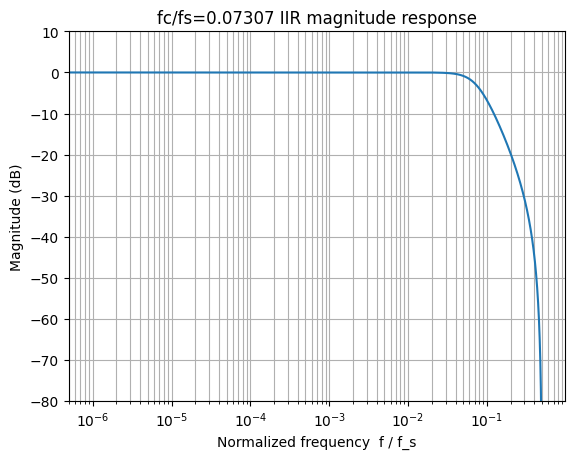

In [17]:
# 传统的二阶IIR的仿真代码：模型搭建 + 幅频响应

def H_IIR(b, a, w):
    z_1 = np.exp(-1j * w)
    return (b[0] + b[1] * z_1 + b[2] * z_1**2) / (a[0] + a[1] * z_1 + a[2] * z_1**2)

def mag_db(x):
    mag = np.abs(x)
    mag[mag == 0] = np.finfo(float).tiny
    return 20.0 * np.log10(mag)
    
N = 4096*128
w = np.linspace(0.0, math.pi, N)
f_norm = w / (2.0 * math.pi)
fc_fs_ratio = 0.073070
b, a = butter(2, 2*fc_fs_ratio, btype='low')

H = H_IIR(b, a, w)
plt.xscale('log')
plt.grid(True, which="both")
plt.plot(f_norm, mag_db(H))
# plt.xlim(0, 0.01)
plt.ylim(-80, 10)
plt.xlabel("Normalized frequency  f / f_s")
plt.ylabel("Magnitude (dB)")
plt.title("fc/fs={} IIR magnitude response".format(fc_fs_ratio))


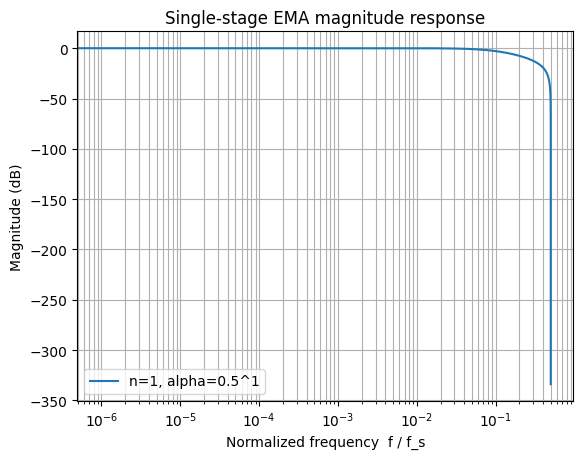

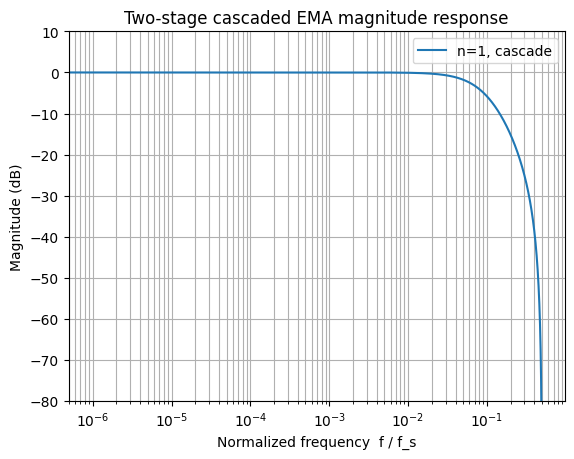

In [ ]:
# # EMA的一阶IIR仿真代码：
# v1: y[n]=αx[n]+(1−α)y[n−1],0<α≤1 
# v2: y[n]=0.5αx[n]+0.5αx[n−1]+(1−α)y[n−1],0<α≤1

def H_ema(alpha, w):
    p = 1.0 - alpha
    # return alpha / (1.0 - p * np.exp(-1j * w))
    return (0.5*alpha + 0.5*alpha*np.exp(-1j * w))/ (1.0 - p * np.exp(-1j * w))

def mag_db(x):
    mag = np.abs(x)
    mag[mag == 0] = np.finfo(float).tiny
    return 20.0 * np.log10(mag)

n_list = [1]
# n_list = [0,1,2,3,4,5,6,7]
N = 4096*128
w = np.linspace(0.0, math.pi, N)
f_norm = w / (2.0 * math.pi)
# Single-stage
plt.figure()
for n in n_list:
    a = 0.5 ** n
    H = H_ema(a, w)
    # plt.xlim(0, 0.01)
    plt.xscale('log')
    plt.plot(f_norm, mag_db(H), label=f"n={n}, alpha=0.5^{n}")
plt.grid(True, which="both")
# plt.ylim(-80, 0)
plt.xlabel("Normalized frequency  f / f_s")
plt.ylabel("Magnitude (dB)")
plt.title("Single-stage EMA magnitude response")
plt.legend()

# simple Two-stage
plt.figure()
for n in n_list:
    a = 0.5 ** n
    H = H_ema(a, w)
    H2 = H * H
    # plt.xlim(0, 0.01)
    plt.xscale('log')
    plt.plot(f_norm, mag_db(H2), label=f"n={n}, cascade")
plt.grid(True, which="both")
plt.xlabel("Normalized frequency  f / f_s")
plt.ylabel("Magnitude (dB)")
plt.ylim(-80, 10)
plt.title("Two-stage cascaded EMA magnitude response")
plt.legend()
plt.show()


In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

# ----- 公共函数 -----
def H_ema(alpha, w):
    """一阶 EMA 频响：H(e^{jw}) = alpha / (1 - (1-alpha) e^{-jw})"""
    p = 1.0 - alpha
    return alpha / (1.0 - p * np.exp(-1j * w))

def mag_db(x):
    mag = np.abs(x)
    mag[mag == 0] = np.finfo(float).tiny
    return 20.0 * np.log10(mag)

def fc_onepole_analytic(alpha):
    """
    单级 EMA 的 -3 dB 截止（角频率，rad/sample）的解析解：
    令 p = 1 - alpha, 由 |H|^2 = 1/2 得 cos(wc) = (-1 + 4p - p^2) / (2p)
    返回 wc；若 alpha=1（直通）或无解，返回 None
    """
    p = 1.0 - alpha
    if p == 0.0:
        return None
    val = (-1.0 + 4.0 * p - p * p) / (2.0 * p)
    if not (-1.0 <= val <= 1.0):
        return None
    return math.acos(val)

def fc_norm_from_w(wc):
    """角频率 -> 归一化频率 f/f_s"""
    return wc / (2.0 * math.pi) if wc is not None else float('nan')

def fc_cascade_numeric(alpha1, alpha2, N=262144):
    """
    两级 EMA 级联（alpha1 != alpha2 时）整体 -3 dB 截止（归一化频率 f/f_s）的数值求解：
    解 |H1*H2| = 1/sqrt(2)
    """
    w = np.linspace(0.0, math.pi, N)
    H1 = H_ema(alpha1, w)
    H2 = H_ema(alpha2, w)
    Htot = H1 * H2
    mag = np.abs(Htot)
    target = 1.0 / math.sqrt(2.0)  # -3 dB

    # 找到第一个低于目标的位置并做线性插值
    idx = np.where(mag <= target)[0]
    if len(idx) == 0:
        return float('nan')
    i = idx[0]
    if i == 0:
        wc = w[0]
    else:
        y1, y2 = mag[i-1], mag[i]
        x1, x2 = w[i-1], w[i]
        t = (target - y1) / (y2 - y1)
        wc = x1 + t * (x2 - x1)
    return wc / (2.0 * math.pi)

# ====== 你的原有参数 ======
n_list = [0,1,2,3,4,5,6,7]
N = 4096*128
w = np.linspace(0.0, math.pi, N)
f_norm = w / (2.0 * math.pi)


# ====== 新增：两级不同 n1, n2 的 -3 dB 截止 ======
# pairs_list = [(i,j) for i in n_list for j in n_list if i != j]
pairs_list = [(i,j) for i in n_list for j in n_list if j>=i]
fc_tot_list = []

print("\nTwo-stage EMA (alpha1 != alpha2) -3 dB cutoff (normalized):")
print(" n1  n2   alpha1    alpha2    fc1_norm   fc2_norm   fc_total_norm")
for (n1, n2) in pairs_list:
    a1 = 0.5 ** n1
    a2 = 0.5 ** n2
    # 单级 -3 dB（解析）
    fc1 = fc_norm_from_w(fc_onepole_analytic(a1))
    fc2 = fc_norm_from_w(fc_onepole_analytic(a2))
    # 级联整体 -3 dB（数值）
    fc_tot = fc_cascade_numeric(a1, a2, N=262144)
    fc_tot_list.append(fc_tot)
    print(f"{n1:3d} {n2:3d}  {a1:8.5f}  {a2:8.5f}  {fc1:9.6f}  {fc2:9.6f}  {fc_tot:13.6f}")

# 排序去重后打印
# 去掉 NaN
vals = [v for v in fc_tot_list if not (isinstance(v, float) and math.isnan(v))]
# 精确去重并降序
fc_sorted_unique = sorted(set(vals), reverse=True)

# 打印
print("fc_total_norm（降序，去重）：")
for i, f in enumerate(fc_sorted_unique, 1):
    print(f"{i:2d}: {f:.12f}")

# # ====== 可选：画出这些不同(n1,n2)的级联幅频 ======
# plt.figure()
# for (n1, n2) in pairs_list:
#     a1 = 0.5 ** n1
#     a2 = 0.5 ** n2
#     H = H_ema(a1, w) * H_ema(a2, w)
#     plt.xlim(0, 0.01)
#     plt.plot(f_norm, mag_db(H), label=f"(n1,n2)=({n1},{n2})")
# plt.grid(True, which="both")
# plt.xlabel("Normalized frequency  f / f_s")
# plt.ylabel("Magnitude (dB)")
# plt.title("Two-stage cascaded EMA (alpha1 != alpha2)")
# plt.legend()

# plt.show()



Two-stage EMA (alpha1 != alpha2) -3 dB cutoff (normalized):
 n1  n2   alpha1    alpha2    fc1_norm   fc2_norm   fc_total_norm
  0   0   1.00000   1.00000        nan        nan            nan
  0   1   1.00000   0.50000        nan   0.115027       0.115027
  0   2   1.00000   0.25000        nan   0.046105       0.046105
  0   3   1.00000   0.12500        nan   0.021284       0.021284
  0   4   1.00000   0.06250        nan   0.010275       0.010275
  0   5   1.00000   0.03125        nan   0.005053       0.005053
  0   6   1.00000   0.01562        nan   0.002506       0.002506
  0   7   1.00000   0.00781        nan   0.001248       0.001248
  1   1   0.50000   0.50000   0.115027   0.115027       0.073070
  1   2   0.50000   0.25000   0.115027   0.046105       0.040477
  1   3   0.50000   0.12500   0.115027   0.021284       0.020583
  1   4   0.50000   0.06250   0.115027   0.010275       0.010191
  1   5   0.50000   0.03125   0.115027   0.005053       0.005043
  1   6   0.50000   0.01562 